<img width="150" alt="Logo_ER10" src="https://user-images.githubusercontent.com/3244249/151994514-b584b984-a148-4ade-80ee-0f88b0aefa45.png">

### Model interpretation using Kernel SHAP (SHapley Additive exPlanations) for  terrestrial water-energy-carbon fluxes

This notebook shows how to apply the Kernel SHAP explainability method on a model trained to predict "**latent heat flux (LEtot)**". 

#### Research context: 
We use a Random Forest model that predicts "LEtot" using a set of **land-atmosphere** variables (in-situ measurments). The model's training workflow and data are based on research carried by "Qianqian Han" https://doi.org/10.5194/egusphere-egu24-5488 as a part of [EcoExtreML](https://research-software-directory.org/projects/ecoextreml) project. For this notebook, a subset of in-situ measurments and simulations from the year 2014 has been chosen to train the model. The time series data are organized into a 2D dataframe. In this dataframe, each row represents a single data instance at a specific time and location, while each column corresponds to a different variable name, as shown below. The simulated "LEtot" data are the results of a physical model [STEMMUS_SCOPE](https://github.com/EcoExtreML/STEMMUS_SCOPE) applied on different locations on the globe. The goal is to use the random forest model as an [emulator](https://github.com/EcoExtreML/Emulator) to predict global maps of "LEtot".

#### Values of Kernel SHAP method:
Kernel SHAP (SHapley Additive exPlanations) values are a unified measure of feature importance that allocates the contribution of each feature to the prediction for a specific instance. In the context of a regression problem, the interpretation of Kernel SHAP values is as follows:

- **Magnitude**: The magnitude of a SHAP value for a feature indicates the degree to which that feature affects the prediction. A larger absolute SHAP value means that the feature has a stronger impact on the output.
- **Sign**: The sign of a SHAP value indicates the direction of the effect. A positive SHAP value for a feature indicates that the presence of that feature increases the model's output, while a negative SHAP value indicates that the presence of that feature decreases the model's output.
- **Zero**: A SHAP value of zero for a feature indicates that the feature did not contribute to the prediction for that specific instance.

It's important to note that SHAP values are instance-specific. 

#### Colab Setup

In [1]:
running_in_colab = 'google.colab' in str(get_ipython())
if running_in_colab:
    # install dianna
    !python3 -m pip install dianna[notebooks]

#### 0 - Libraries

In [2]:
import pandas as pd
import numpy as np
from joblib import load
from sklearn.model_selection import train_test_split

import dianna
from dianna import visualization
from dianna.utils import SimpleModelRunner
from dianna.utils.downloader import download

# for plotting purpuses
import os
import shap
import textwrap
import matplotlib.pyplot as plt
from shap import Explanation

np.random.seed(0)

#### 1- Load and visualize the data

In [3]:
# this data covers only one year of data i.e. 2014
data_path = download('stemmus_scope_emulator_train_test_2014_data.csv', 'data')

In [4]:
dataset = pd.read_csv(data_path)
dataset

,Unnamed: 0,station,date_UTC,Precip_msr,Rin,Rli,p,Ta,ea,u,...,IGBP_veg_long2,IGBP_veg_long3,IGBP_veg_long4,IGBP_veg_long5,IGBP_veg_long6,IGBP_veg_long7,IGBP_veg_long8,IGBP_veg_long9,IGBP_veg_long10,IGBP_veg_long11
0,0,AU-ASM,2013-12-31 15:00:00,0.0,0.000000,422.350995,940.534220,31.677529,0.087688,2.134386,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,AU-ASM,2013-12-31 16:00:00,0.0,0.000000,405.639800,932.560705,31.299402,0.099312,1.201066,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,AU-ASM,2013-12-31 17:00:00,0.0,0.000000,413.726000,939.196055,30.007821,0.107478,1.354100,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,AU-ASM,2013-12-31 18:00:00,0.0,0.000000,412.545700,940.048085,30.011499,0.110519,1.795051,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,AU-ASM,2013-12-31 19:00:00,0.0,0.000000,381.210585,940.882070,29.375940,0.112046,1.729858,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136583,136583,US-Myb,2014-03-14 22:00:00,0.0,691.839510,315.739010,1023.000000,20.380014,10.184294,2.369500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
136584,136584,US-Myb,2014-03-14 23:00:00,0.0,536.578495,315.739010,1022.500000,21.415002,10.509555,1.799000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
136585,136585,US-Myb,2014-03-15 00:00:00,0.0,346.486005,309.051010,1022.200000,22.374994,10.878103,1.528500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
136586,136586,US-Myb,2014-03-15 01:00:00,0.0,150.326500,302.363010,1022.150000,22.409997,10.705077,1.653500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [5]:
# test, train data
dataset['date_UTC'] = pd.to_datetime(dataset['date_UTC'])

x_vars = ['station', 'date_UTC', 'Rin', 'Rli', 'p', 'Ta', 'ea', 'u', 'CO2', 'LAI','Vcmo', 'hc', 'Precip_msr','SSM', *[f'IGBP_veg_long{i}' for i in range(1, 12)]]
x = dataset[x_vars]

y_vars = ['station', 'date_UTC', 'LEtot']
y = dataset[y_vars]

# Note: These are not exactly the same data on which model was trained because of randomness in train_test_split!
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=0, shuffle=True)

# sort based on time
x_test = x_test.sort_values('date_UTC')
y_test = y_test.sort_values('date_UTC')

x_train = x_train.sort_values('date_UTC')
y_train = y_train.sort_values('date_UTC')

#### 2- Load the model

In [6]:
def preprocess(data):
    data_reshaped = data
    if len(data.shape) == 1:
        data_reshaped = data.reshape(1,-1)
    return data_reshaped.astype(np.float32)

# this model is trained on the data of 2014
model_path = download('stemmus_scope_emulator_model_LEtot.onnx', 'model')
runner = SimpleModelRunner(model_path, preprocess_function=preprocess)

##### Inspect the performance of the model 

Here, the correlation and relative mean absolute error (MAE) are calculated using test data

In [7]:
features = x_test.drop(columns=['station', 'date_UTC']).fillna(0)
y_predict = runner(features.to_numpy())
y_actual = y_test.drop(columns=['station', 'date_UTC']).fillna(0).to_numpy()

relative_mae = np.mean(np.abs(y_predict - y_actual))/ np.mean(y_actual)
cor = np.corrcoef(y_predict.T, y_actual.T)[0,1]
print(f"Relative MAE is {relative_mae} and correlation is {cor}")

Relative MAE is 0.09253918269272535 and correlation is 0.9868130054495278


#### 3 - Example: Run the explainer for one sample (data instance)

First we run DIANNA on a single data instance to show how to run DIANNA with this dataset.

In [8]:
# select one instance to be explained
features = x_test.drop(columns=['station', 'date_UTC']).fillna(0)
data_instance = features.iloc[0].values.reshape(1, -1)

# The background dataset to use for integrating out features (see shap documentation)
# the number of clusters 5 is determind using kmean inertia plot, see
# https://scikit-learn.org/stable/modules/clustering.html#k-means
background_data = x_train.drop(columns=['station', 'date_UTC']).fillna(0).to_numpy()

In [9]:
%%time
explanation = dianna.explain_tabular(runner, input_tabular=data_instance, method='kernelshap',
                                     mode ='regression', training_data=background_data, training_data_kmeans=5,
                                     feature_names=features.columns)

  0%|          | 0/1 [00:00<?, ?it/s]

CPU times: user 8.87 s, sys: 4.55 s, total: 13.4 s
Wall time: 2.34 s


#### 4 - Visualize the results

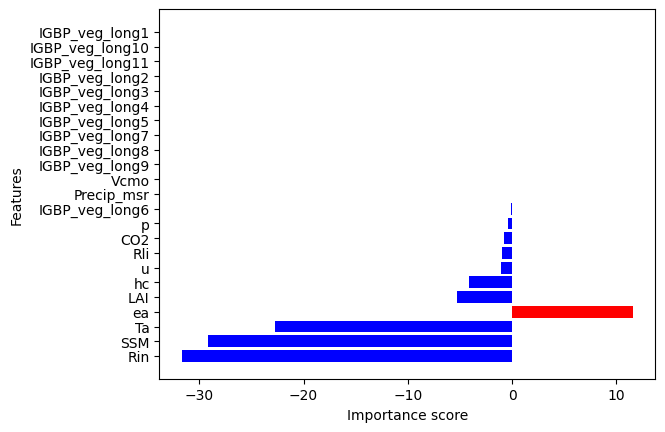

In [10]:
_ = visualization.plot_tabular(explanation[0], features.columns, num_features=len(features.columns))

##### some insights
The figure shows that the values of Ta, SSM, Rin in this sample had a negative effect on model's predicted value for that instance, while the value of ea had a positive effect. Some of the variables uch as IGBP and Precip_msr variables, have SHAP values of zero, indicating they did not contribute to the predictions. Let's have a look at other instances.

#### 5 -  Run the explainer at one location, several data instances (here as an example one month time series)

To investigate feature importance in general for a single location, we now run multiple data-instances through our DIANNA pipeline and inspect the results.

##### 5.1 - define some functions for visualizations

The code in the following cell is necessary to display all visualizations, with their captions, side-by-side for convenient viewing.

In [11]:
def display_figures(figures, captions, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(24, 8))
    for i, figure in enumerate(figures):
        figure.set_size_inches(8, 8)
        figure.savefig(f'fig{i}.png', dpi=100)
        image_data = plt.imread(f'fig{i}.png')
        ax[i].imshow(image_data)
        ax[i].axis('off')
        wrapped_caption = textwrap.fill(captions[i], width=60)
        ax[i].text(0.5, -0.2, wrapped_caption, size=10, ha="center",
                   transform=ax[i].transAxes)
        # Remove the temporary file
        os.remove(f'fig{i}.png')
    plt.show()


def comparison_plot(y_actual, y_pred, show=True):
    plt.plot(y_actual, label='Actual', color="blue", linewidth=3, alpha=0.7)
    plt.plot(y_pred, label='Prediction', color="orange")
    plt.xlabel('time index')
    plt.ylabel('LEtot')
    plt.legend()
    if show:
        plt.show()

captions = ["Fig 1: Prediction vs Actual time series using test data. The x axis is time index.", 
            "Fig 2: Heatamp. The x axis is time index. The y axis is the feature names. The colorbar shows the shap values. "
            "The f(x) graph shows the cumulative SHAP values across all features for each sample, "
            "highlighting the relative importance of features across different samples.", 
            "Fig 3: Summary. The x axis is shap values. The colorbar shows the range of each feature values (from low to high)."]

In [12]:
# to store explanations values
explanations = {}

In [13]:
# select one location and time steps
location = "US-Myb"
month = 1
key = f"{location}_{month}"

x_test_time = x_test[(x_test["station"] == location) & (x_test["date_UTC"].dt.month == month)]
features = x_test_time.drop(columns=['station', 'date_UTC']).fillna(0)
background_data = x_train.drop(columns=['station', 'date_UTC']).fillna(0).to_numpy()

This step takes a few minutes, so not suitable for github actions. If you want to run this step locally, set `locally_run = True`.

In [1]:
locally_run = False

In [14]:
# run explainer over time series, this might take a few minutes
if locally_run:
    explanations[key] = dianna.explain_tabular(runner, input_tabular=features.values, method='kernelshap',
                                              mode ='regression', training_data=background_data, training_data_kmeans=5,
                                              feature_names=features.columns, silent=True)
    
    print("Dianna is done!") 

Dianna is done!


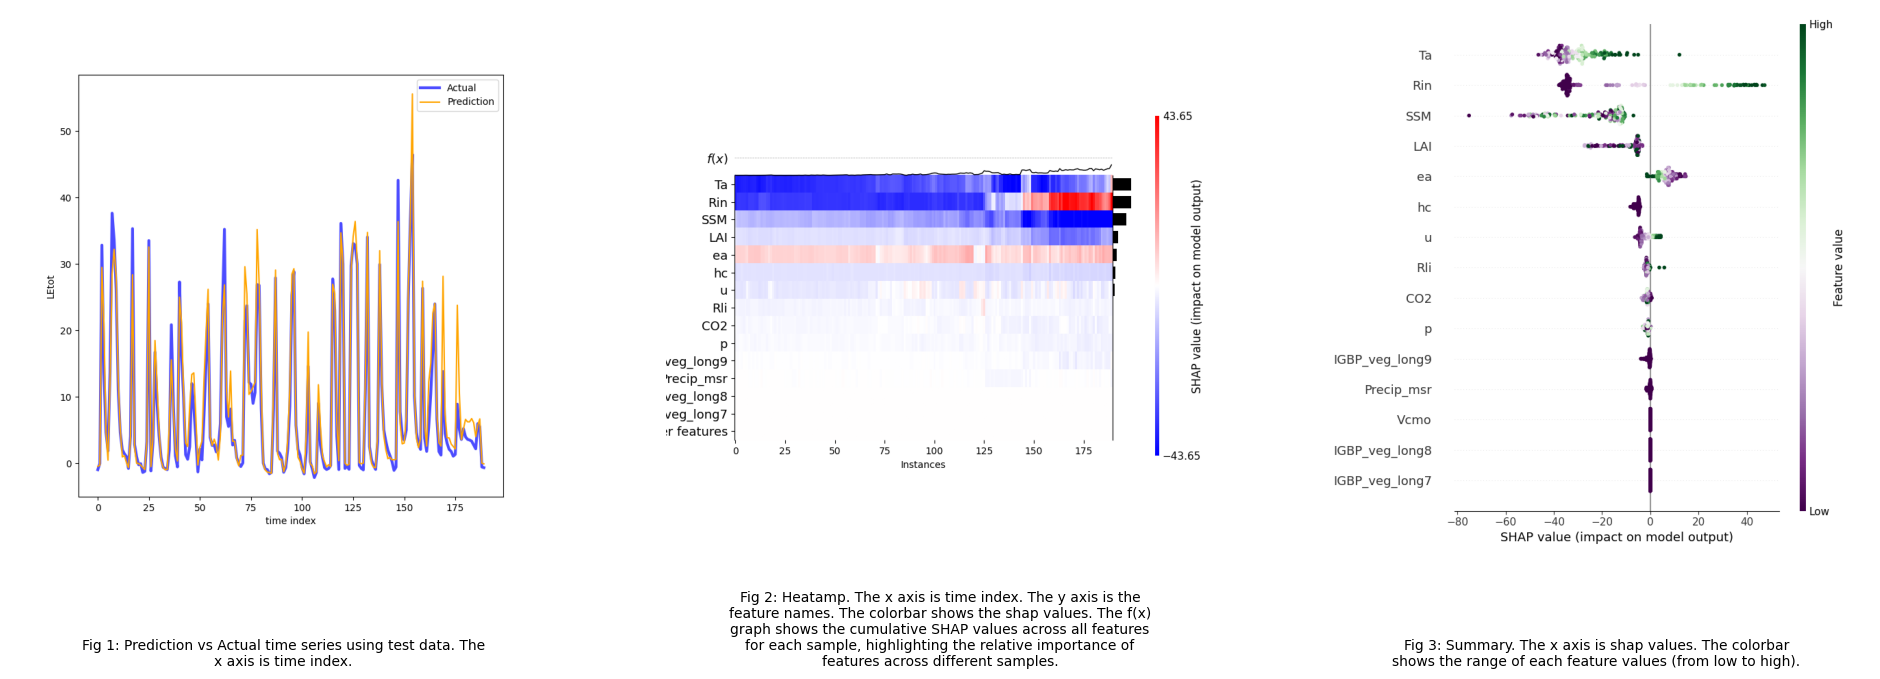

In [15]:
if locally_run:
    # create shap_values object
    shap_values = Explanation(explanations[key])
    shap_values.feature_names = features.columns
    
    # create comparison plot: predictions vs test data 
    y_predict_time = runner(features.to_numpy())
    y_test_time = y_test[(y_test["station"] == location) & (y_test["date_UTC"].dt.month == month)].drop(columns=['station', 'date_UTC']).fillna(0).to_numpy()
    comparison_plot(y_test_time, y_predict_time, show=False)    
    comparison_img = plt.gcf()
    plt.close()
    
    # create summary plot
    shap.summary_plot(shap_values, features.values, feature_names=features.columns, cmap="PRGn", show=False, max_display=15)
    summary_img = plt.gcf()
    plt.close()
    
    # create heatmap plot
    shap.plots.heatmap(shap_values, cmap="bwr", show=False, max_display=15)
    heatmap_img = plt.gcf()
    plt.close()
    
    # plot all three figures in one cell
    figures = [comparison_img, heatmap_img, summary_img]
    display_figures(figures, captions, 1, 3)

In [16]:
if locally_run:
    relative_mae = np.mean(np.abs(y_predict_time - y_test_time))/ np.mean(y_test_time)
    cor = np.corrcoef(y_predict_time.T, y_test_time.T)[0,1]
    print(f"Relative MAE is {relative_mae} and correlation is {cor}")

Relative MAE is 0.2215188921211095 and correlation is 0.9700512335266412


##### some insights
Figure 1 illustrates that under-predictions (where predicted values are lower than actual test values) predominantly occur in the first half of the time series. To understand this behavior, we can examine the SHAP values for further insights. As shown in Figure 2, the SHAP values for three variables (Ta, Rin, and SSM) are largely negative in the first half of the time series. According to SHAP definitions, these three variables are contributing most to this under-predictions. Figure 3 reveals that both high and low values of Ta and SSM lead to negative SHAP values, while only low values of Rin result in negative SHAP values.

Conversely, Figure 1 shows that over-predictions (where predicted values are higher than actual test values) mainly occur in the latter part of the time series. To investigate the cause of these spikes, we again refer to the SHAP values. Figure 2 indicates that the SHAP values of Rin are strongly positive in the latter part of the time series. Additionally, the SHAP values of SSM remain strongly negative in this part of the series. From Figure 3, we observe that only high values of Rin lead to high positive SHAP values and are contributing most to over-predictions.

Another observation from Figures 2 and 3 is that several variables, such as IGBP and Precip_msr variables, have SHAP values of zero, indicating they did not contribute to the predictions.

### Select a different location and month

Now we are going to investigate the feature importance for a different location and time.

In [17]:
# select one location and time steps
location = "US-Me6"
month = 2
key = f"{location}_{month}"

x_test_time = x_test[(x_test["station"] == location) & (x_test["date_UTC"].dt.month == month)]
features = x_test_time.drop(columns=['station', 'date_UTC']).fillna(0)
background_data = x_train.drop(columns=['station', 'date_UTC']).fillna(0).to_numpy()

In [18]:
if locally_run:
    # run explainer over time series, this might take a few minutes
    explanations[key] = dianna.explain_tabular(runner, input_tabular=features.values, method='kernelshap',
                                              mode ='regression', training_data=background_data, training_data_kmeans=5,
                                              feature_names=features.columns, silent=True)
    
    print("Dianna is done!") 

Dianna is done!


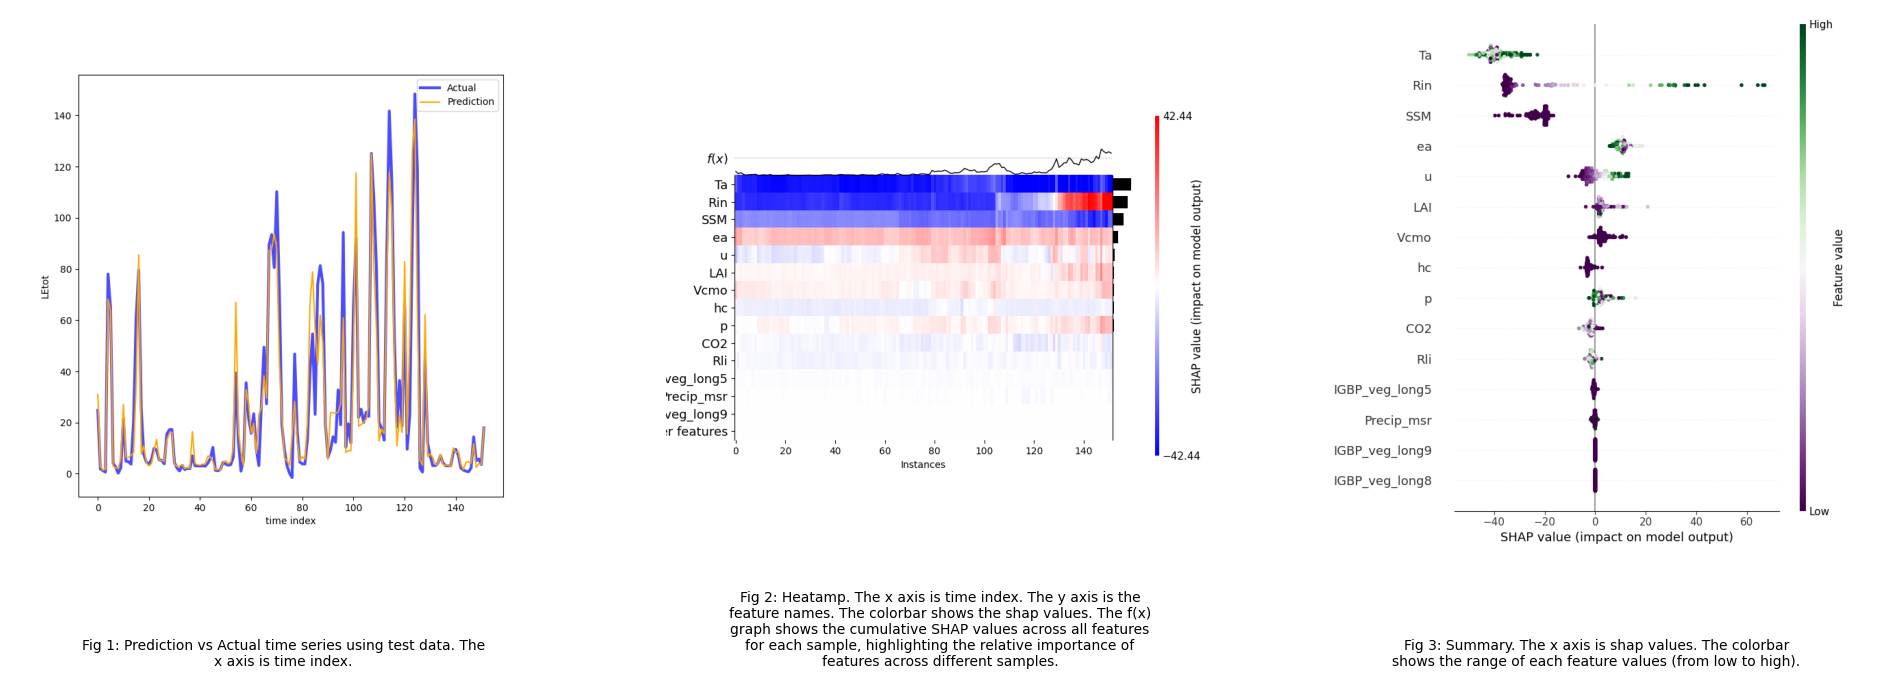

In [19]:
if locally_run:
    # create shap_values object
    shap_values = Explanation(explanations[key])
    shap_values.feature_names = features.columns
    
    # create comparison plot: predictions vs test data 
    y_predict_time = runner(features.to_numpy())
    y_test_time = y_test[(y_test["station"] == location) & (y_test["date_UTC"].dt.month == month)].drop(columns=['station', 'date_UTC']).fillna(0).to_numpy()
    comparison_plot(y_test_time, y_predict_time, show=False)    
    comparison_img = plt.gcf()
    plt.close()
    
    # create summary plot
    shap.summary_plot(shap_values, features.values, feature_names=features.columns, cmap="PRGn", show=False, max_display=15)
    summary_img = plt.gcf()
    plt.close()
    
    # create heatmap plot
    shap.plots.heatmap(shap_values, cmap="bwr", show=False, max_display=15)
    heatmap_img = plt.gcf()
    plt.close()
    
    # plot all three figures in one cell
    figures = [comparison_img, heatmap_img, summary_img]
    display_figures(figures, captions, 1, 3)

In [20]:
if locally_run:
    relative_mae = np.mean(np.abs(y_predict_time - y_test_time))/ np.mean(y_test_time)
    cor = np.corrcoef(y_predict_time.T, y_test_time.T)[0,1]
    print(f"Relative MAE is {relative_mae} and correlation is {cor}")

Relative MAE is 0.27991943305822775 and correlation is 0.9344053781949128


##### some insights
Figure 1 illustrates that under-predictions (where predicted values are lower than actual test values) predominantly occur in the middle of the time series. To understand this behavior, we can examine the SHAP values for further insights. As shown in Figure 2, the SHAP values for three variables (Ta, Rin, and SSM) are largely negative in the middle of the time series. According to SHAP definitions, these three variables are contributing most to this under-predictions. Figure 3 reveals that both high and low values of Ta and SSM lead to negative SHAP values, while only low values of Rin result in negative SHAP values.

Another observation from Figures 2 and 3 is that several variables, such as IGBP and Precip_msr variables, have SHAP values of zero, indicating they did not contribute to the predictions.

##### zoom in
Figure 1 illustrates that at time index = 96 there is an under-predictions (where predicted value is  61.001163 whereas actual value is 94.3072815). To understand this, let's zoom in to the data and ask diannan to explain this instance.

  0%|          | 0/1 [00:00<?, ?it/s]

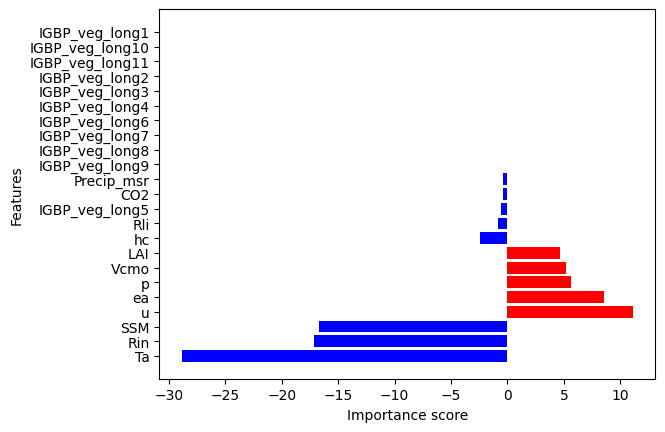

In [21]:
# select data where there is a large under-predictions
data_instance = features.iloc[96].values.reshape(1, -1) 
explanation = dianna.explain_tabular(runner, input_tabular=data_instance, method='kernelshap',
                                     mode ='regression', training_data=background_data, training_data_kmeans=5,
                                     feature_names=features.columns)
_ = visualization.plot_tabular(explanation[0], features.columns, num_features=len(features.columns))

##### some insights
This figure illustrates that the variable Ta is contributing (negatively) most to this under-predictions.

##### another zoom in
Figure 1 illustrates that at time index = 101 there is an over-predictions (where predicted value is 117.56776 whereas actual value is 92.1536555). To understand this, let's zoom in to the data and ask diannan to explain this instance.

  0%|          | 0/1 [00:00<?, ?it/s]

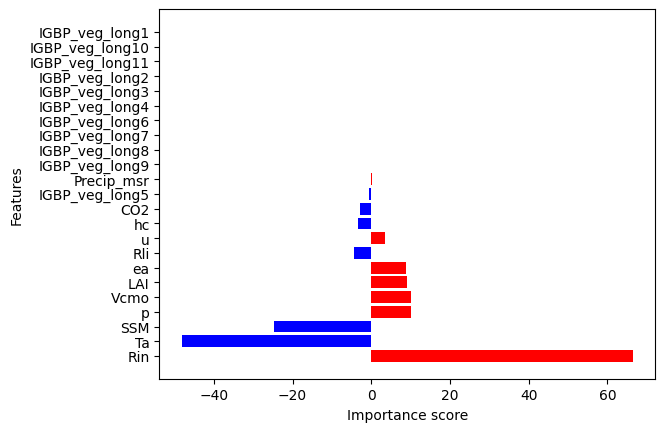

In [22]:
# select data where there is a large over-predictions
data_instance = features.iloc[101].values.reshape(1, -1) 
explanation = dianna.explain_tabular(runner, input_tabular=data_instance, method='kernelshap',
                                     mode ='regression', training_data=background_data, training_data_kmeans=5,
                                     feature_names=features.columns)
_ = visualization.plot_tabular(explanation[0], features.columns, num_features=len(features.columns))

##### some insights
This figure illustrates that the variable Rin is contributing (positively) most to this over-predictions.

### 6. Conclusion

In this notebook, we use a Random Forest model to predict "latent heat flux (LEtot)" using a set of 23 land-atmosphere features. To interpret the model's predictions, we run the KernelSHAP method via Dianna to assess the contribution of each feature to the output. The shap values showed that the features Ta, Rin, and SSM hold the greatest importance, while variables such as IGBP and Precip_msr did not contribute to the predictions.